<div class='alert'>

### Fine Tuning LLM - GPT2

</div>

<div class='alert alert-success'>
Lets Start.

We will follow these steps:
1. Choose a pre-trained model and a dataset
2. Load the data
3. Tokenizer
4. Initialize our base model
5. Evaluate the method
6. Fine tune using the Trainer method
</div>

<div class='alert'>

#### 1. Choose a pre-trained model and a dataset

</div>

Lets use *`gpt2`* model and a *`twitter dataset`*.

<div class='alert'>

#### 2. Load the dataset

</div>

In [1]:
# load the dataset
from datasets import load_dataset

twitter_dataset = load_dataset("mteb/tweet_sentiment_extraction")
twitter_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 27481
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 3534
    })
})

In [2]:
import pandas as pd
import pprint

training_dataset = pd.DataFrame(twitter_dataset['train'])
testing_dataset = pd.DataFrame(twitter_dataset['test'])

training_dataset.set_index('id', inplace=True)
testing_dataset.set_index('id', inplace=True)

training_dataset.head()

,text,label,label_text
id,,,
cb774db0d1,"I`d have responded, if I were going",1,neutral
549e992a42,Sooo SAD I will miss you here in San Diego!!!,0,negative
088c60f138,my boss is bullying me...,0,negative
9642c003ef,what interview! leave me alone,0,negative
358bd9e861,"Sons of ****, why couldn`t they put them on t...",0,negative


In [3]:
training_dataset.shape, testing_dataset.shape, training_dataset['label_text'].unique()

((27481, 3),
 (3534, 3),
 array(['neutral', 'negative', 'positive'], dtype=object))

We see that the labels are `neutral`, `negative`, and `positive`.

So our goal is to classify the sentiment of the `text` into those `labels`

In [4]:
# check if the labels have balanced data
total_neutral = len(training_dataset[training_dataset['label'] == 1])
total_negative = len(training_dataset[training_dataset['label'] == 0])
total_positive = len(training_dataset[training_dataset['label'] == 2])

total_neutral, total_negative, total_positive

(11118, 7781, 8582)

<BarContainer object of 3 artists>

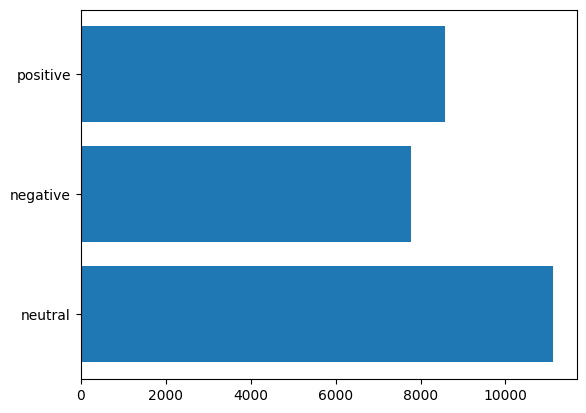

In [5]:
import matplotlib.pyplot as plt

plt.barh(['neutral', 'negative', 'positive'], [total_neutral, total_negative, total_positive])

Looks like neutral has more data. but its not a lot, so it is acceptable.

<div class='alert'>

#### 3. Load the tokenizer

</div>

In [6]:
# load the model
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')

As LLMs work with tokens, we need to tokenize our entire dataset using the tokenizer.

We can use map method to apply the preprocessing function over the entire dataset.

In [7]:
from transformers import GPT2Tokenizer
# d = load_dataset("mteb/tweet_sentiment_extraction")

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
# t.pad_token

In [8]:
# tokenizer.pad_token = tokenizer.eos_token

def tokenize_function(observation):
    return tokenizer(observation['text'], padding='max_length', truncation=True)

tokenized_dataset = twitter_dataset.map(tokenize_function, batched=True)


In [9]:
tokenized_dataset['train'], tokenized_dataset['test']

(Dataset({
     features: ['id', 'text', 'label', 'label_text', 'input_ids', 'attention_mask'],
     num_rows: 27481
 }),
 Dataset({
     features: ['id', 'text', 'label', 'label_text', 'input_ids', 'attention_mask'],
     num_rows: 3534
 }))

<div class='alert'>

#### 4. Initialize our base model

</div>

In [10]:
# model = AutoModelForMaskedLM.from_pretrained('google-bert/bert-base-uncased', num_labels=3)

from transformers import GPT2ForSequenceClassification

model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=3)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<div class='alert'>

#### 5. Evaluate

</div>

In [ ]:
import evaluate
import numpy as np

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)

   return metric.compute(predictions=predictions, references=labels)

<div class='alert'>

#### 6. Fine-tune the model

</div>

In [12]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
   output_dir="test_trainer",
   #evaluation_strategy="epoch",
   per_device_train_batch_size=1,  # Reduce batch size here
   per_device_eval_batch_size=1,    # Optionally, reduce for evaluation as well
   gradient_accumulation_steps=4
)


trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_dataset['train'],
   eval_dataset=tokenized_dataset['test'],
   compute_metrics=compute_metrics,

)

trainer.train()


Step,Training Loss
500,0.883400
1000,0.723400
1500,0.725400
2000,0.719200
2500,0.657300
3000,0.681800
3500,0.663300
4000,0.655700
4500,0.669000
5000,0.679600


TrainOutput(global_step=20610, training_loss=0.5891319002820589, metrics={'train_runtime': 13970.0241, 'train_samples_per_second': 5.901, 'train_steps_per_second': 1.475, 'total_flos': 4.307986164901478e+16, 'train_loss': 0.5891319002820589, 'epoch': 2.9996725010006915})

In [39]:
# import torch

# model_state_dict = torch.load('test_trainer/checkpoint-20610/rng_state.pth', weights_only=True)

# model.load_state_dict(model_state_dict)


from transformers import GPT2ForSequenceClassification
model = GPT2ForSequenceClassification.from_pretrained("test_trainer/checkpoint-20610", use_safetensors=True)

When loading a model saved with safetensors format, you need to point to the directory containing the model files, not directly to the model.safetensors file itself. The correct approach would be:

```Python
from transformers import AutoModelForCausalLM

# Incorrect (causing the error)
model = AutoModel.from_pretrained('test_trainer/checkpoint-20610/model.safetensors')

# Correct
model = AutoModel.from_pretrained('test_trainer/checkpoint-20610', use_safetensors=True)
```

In [40]:
model

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=3, bias=False)
)

#### Lets evaluate the trained model now

In [41]:
from transformers import TrainingArguments, Trainer

# configure training argument for the evaluation
training_args = TrainingArguments(
    output_dir='evaluate_model',
    per_device_eval_batch_size=1,
    prediction_loss_only=False
)

# initialize evaluator
evaluator = Trainer(
    model=model,
    args=training_args, # more like evaluating arguments
    # tokenizer = tokenizer, # note we are using  tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    # # eval_dataset=tokenized_dataset['test'],
)


In [42]:
eval_results = evaluator.evaluate(tokenized_dataset['test'])

In [43]:
eval_results

{'eval_loss': 0.9359921216964722,
 'eval_model_preparation_time': 0.0044,
 'eval_runtime': 271.9477,
 'eval_samples_per_second': 12.995,
 'eval_steps_per_second': 12.995}

default trainer doesn't give other metrics.

We have to write a custom function that handles this.

Lets do that now

In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def custom_metrics(predictions):
    pred, labels = predictions
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred, average='macro')
    recall = recall_score(y_true=labels, y_pred=pred, average='macro')
    f1 = f1_score(y_true=labels, y_pred=pred, average='macro')
    # average = macro, we should do this for multiclass classfication
    # we can choose from micro, macro, and weighted options

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

## update the evaluator
evaluator = Trainer(
    model=model,
    args=training_args, # more like evaluating arguments
    compute_metrics=custom_metrics
)

eval_results = evaluator.evaluate(tokenized_dataset['test'])


In [48]:
eval_results

{'eval_loss': 0.9359921216964722,
 'eval_model_preparation_time': 0.0036,
 'eval_accuracy': 0.7874929258630448,
 'eval_precision': 0.788823084619586,
 'eval_recall': 0.7929297659125402,
 'eval_f1': 0.7906929181372236,
 'eval_runtime': 161.2544,
 'eval_samples_per_second': 21.916,
 'eval_steps_per_second': 21.916}

Great!!! 

We got accuracy of around 79%.

![dancing](https://media1.tenor.com/m/RdYowW9KtNMAAAAC/dancing-happy-dance.gif)


But We didnt check the base model's performance before. 

Lets check if the base models performance is less or greater than 79.

In [49]:
base_model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=3)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
## update the evaluator
base_evaluator = Trainer(
    model=base_model,
    args=training_args, # more like evaluating arguments
    compute_metrics=custom_metrics
)

base_eval_results = base_evaluator.evaluate(tokenized_dataset['test'])

base_eval_results

/home/loki/micromamba/envs/agentic/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.4421862363815308,
 'eval_model_preparation_time': 0.0019,
 'eval_accuracy': 0.30220713073005095,
 'eval_precision': 0.2292054310600545,
 'eval_recall': 0.33446553446553445,
 'eval_f1': 0.2146026926803921,
 'eval_runtime': 162.8452,
 'eval_samples_per_second': 21.702,
 'eval_steps_per_second': 21.702}

In [60]:
results = pd.DataFrame([base_eval_results, eval_results], index=['Base Model', 'Fine-tuned Model'])

results.transpose()

,Base Model,Fine-tuned Model
eval_loss,1.442186,0.935992
eval_model_preparation_time,0.001900,0.003600
eval_accuracy,0.302207,0.787493
eval_precision,0.229205,0.788823
eval_recall,0.334466,0.792930
eval_f1,0.214603,0.790693
eval_runtime,162.845200,161.254400
eval_samples_per_second,21.702000,21.916000
eval_steps_per_second,21.702000,21.916000


From the evaluation we can see that the base model has the `accuracy of 30%` which is a lot less than the `79%` accuracy we got from the fine tune model. 

This is great. 

Our fine tuned model is wayyyy better than the base model without fine tune.

We deserve more dance.

![](https://media1.tenor.com/m/Ffl1k0f2bgIAAAAC/dance-moves.gif)